In [ ]:
# Import libraries
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the data
data = pd.read_csv('./water_quality_data.csv', encoding='latin-1')

In [ ]:
# Output info about the columns
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32963 entries, 0 to 32962
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cuerpo Agua  32963 non-null  object 
 1   Estudio      32963 non-null  object 
 2   Parámetro    32963 non-null  object 
 3   Unidad       32963 non-null  object 
 4   Punto        32963 non-null  object 
 5   Abreviatura  32963 non-null  object 
 6   Latitud      32963 non-null  float64
 7   Longitud     32963 non-null  float64
 8   Valor        31464 non-null  float64
dtypes: float64(3), object(6)
memory usage: 2.3+ MB
None


In [ ]:
# Number of distinct dates, parameters and measuring points
print(f'Number of times measurement was taken: {len(data["Estudio"].unique())}')
print(f'Number of parameters: {len(data["Parámetro"].unique())}')
print(f'Number of measuring points: {len(data["Abreviatura"].unique())}')

Number of times measurement was taken: 134
Number of parameters: 46
Number of measuring points: 10


In [ ]:
# Check if all measuring points were equally used during measurements
print(data["Abreviatura"].value_counts())

Abreviatura
LC-03    5775
LC-01    5774
LC-02    5772
LC-04    5731
LC-05    5731
LC-00     880
LC-06     836
LC-07     836
LC-08     836
LC-09     792
Name: count, dtype: int64


**Dealing With Missing Values**

In [ ]:
# Check for missing values in the data
missing = data.isnull().sum()
missing_cols = missing[missing > 0]
print(missing_cols)

Valor    1499
dtype: int64


In [ ]:
# Check which parameters were not captured the most
missing_values_per_param = data[data['Valor'].isnull()][['Parámetro', 'Abreviatura']]
print(missing_values_per_param['Parámetro'].value_counts())
# Check which measuring points had the most missing values
print(missing_values_per_param['Abreviatura'].value_counts())

Parámetro
Transparencia Secchi             501
Profundidad                      383
Clorofilas a, b y c              127
Manganeso                        100
Sodio                             90
Temperatura ambiente              82
Demanda bioquímica de oxígeno     50
Coliformes totales                50
Oxígeno disuelto                  46
Nitrógeno total Kjeldahl          20
Sulfuros                          12
Nitrógeno total                   10
Grasas y aceites                  10
Nitrógeno amoniacal               10
Dureza total                       4
Arsénico                           2
Coliformes fecales                 1
Temperatura                        1
Name: count, dtype: int64
Abreviatura
LC-01    254
LC-02    253
LC-03    251
LC-05    250
LC-04    248
LC-06     50
LC-00     49
LC-07     48
LC-08     48
LC-09     48
Name: count, dtype: int64


In [ ]:
# Calculate the mean of each parameter  for each measuring point
mean_vals = (
    data.groupby(["Parámetro", "Abreviatura"])["Valor"]
    .transform(lambda x: x.fillna(x.mean()))
)

# Get the index for the first row with missing measurement value
idx = data[data["Valor"].isnull()].index.tolist()[0]
# Get parameter name and measuring location
missing_row = data.iloc[idx]
param = missing_row["Parámetro"]
abbr = missing_row["Abreviatura"]

# Calculate the mean value for the given parameter and measuring point for validation
subset = data[(data["Parámetro"] == param) & (data["Abreviatura"] == abbr)]
print(f'The mean value for {param} at {abbr} is {subset["Valor"].mean(skipna=True)}')

data["Valor"] = data["Valor"].fillna(mean_vals)
print(f'The update missing value: {data.iloc[idx]["Valor"]}')

The mean value for Demanda bioquímica de oxígeno at LC-01 is 19.129583333333336
The update missing value: 19.129583333333336


In [ ]:
print(data.isnull().sum())

Cuerpo Agua    0
Estudio        0
Parámetro      0
Unidad         0
Punto          0
Abreviatura    0
Latitud        0
Longitud       0
Valor          0
dtype: int64


**Data Visualization**

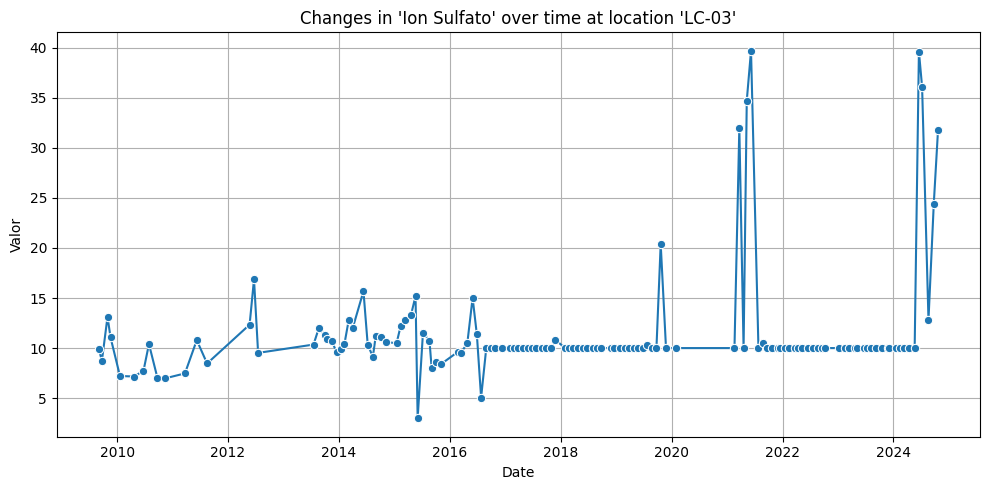

In [ ]:
# Convert Date column into datetime
data['Estudio'] = pd.to_datetime(data['Estudio'], dayfirst=True)

# Example
param = "Ion Sulfato"
abbr = "LC-03"

def visualize_param(data, parameter, measuring_point=None):
    """
        Function used to visualize parameter values over time
        If measuring point is given, visualize only for the point
    """
    if not measuring_point:
        subset = data[data["Parámetro"] == parameter].copy()
        subset = subset.sort_values("Estudio")
    else:
        subset = data[(data["Parámetro"] == parameter) & (data["Abreviatura"] == measuring_point)].copy()
        subset = subset.sort_values("Estudio")

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=subset, x="Estudio", y="Valor", marker="o")
    if not measuring_point:
        plt.title(f"Changes in '{param}' over time")
    else:
        plt.title(f"Changes in '{param}' over time at location '{measuring_point}'")
    plt.xlabel("Date")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_param(data, param, abbr)

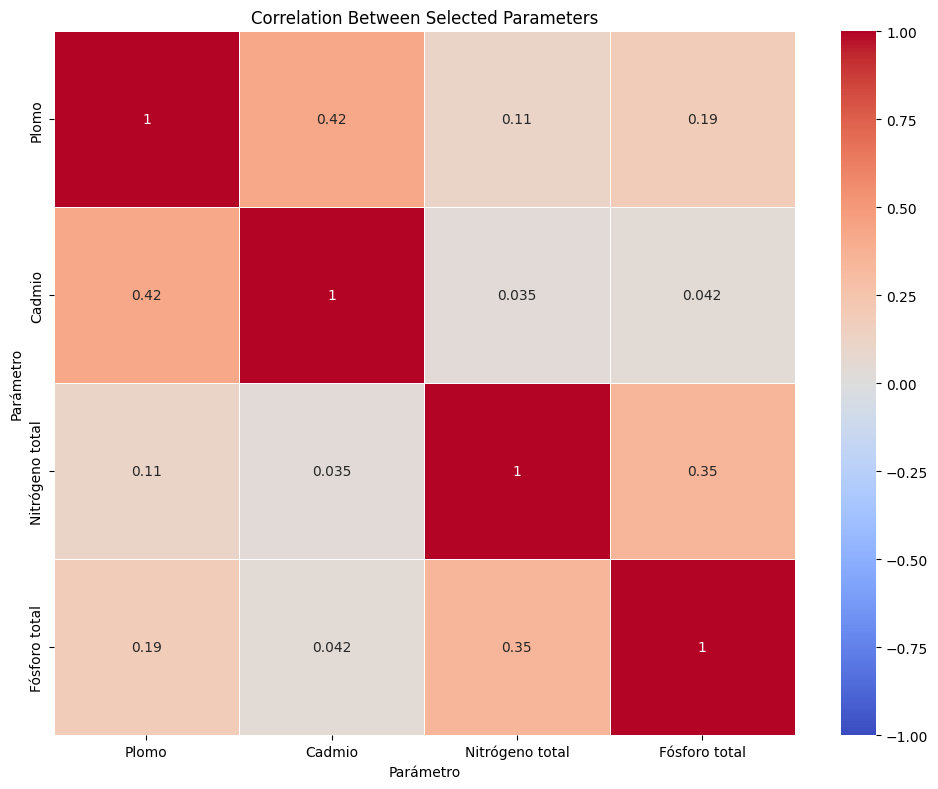

In [ ]:
# Visualize correlation between parameters
def plot_param_correlation(data, param_list):
    """
    Visualizes the correlation matrix between selected parameters.
    """
    # Filter dataset to only include selected parameters
    subset = data[data["Parámetro"].isin(param_list)].copy()

    # Pivot table: rows = (Date, Location), columns = Parameters, values = Valor
    pivot = subset.pivot_table(
        index=["Estudio", "Abreviatura"],
        columns="Parámetro",
        values="Valor",
        aggfunc="mean"
    )

    # Calculate correlation matrix
    corr = pivot[param_list].corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Correlation Between Selected Parameters")
    plt.tight_layout()
    plt.show()

# Example
plot_param_correlation(data, ["Plomo", "Cadmio", "Nitrógeno total", "Fósforo total"])

**Data Cleaning**

In [ ]:
# Pivot data so parameters become columns
pivot_data = data.pivot_table(
    index=["Estudio", "Abreviatura"],
    columns="Parámetro",
    values="Valor"
).reset_index()

print(pivot_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 48 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Estudio                                 753 non-null    datetime64[ns]
 1   Abreviatura                             753 non-null    object        
 2   Alcalinidad total                       742 non-null    float64       
 3   Aluminio                                742 non-null    float64       
 4   Arsénico                                742 non-null    float64       
 5   Bario                                   742 non-null    float64       
 6   Cadmio                                  742 non-null    float64       
 7   Clorofilas a, b y c                     742 non-null    float64       
 8   Cloruros totales                        742 non-null    float64       
 9   Cobre                                   742 non-null  

In [ ]:
# Investigate parameters with low measurement count
rare_params = ["Materia Flotante", "Potencial de hidrógeno", "pH"]
to_drop = []

for rare_param in rare_params:
    first_date = pivot_data[pd.notnull(pivot_data[rare_param])]["Estudio"].min()
    last_date = pivot_data[pd.notnull(pivot_data[rare_param])]["Estudio"].max()
    param_observations = pivot_data[rare_param].count()
    total_observations = len(pivot_data)
    print(f'"{rare_param} was only measured {param_observations}/{total_observations} and between {first_date} - {last_date}"')

# Drop these columns from data
pivot_data = pivot_data.drop(columns=["Materia Flotante", "Potencial de hidrógeno"])
print(pivot_data.info())

"Materia Flotante was only measured 272/753 and between 2013-07-17 00:00:00 - 2018-08-27 00:00:00"
"Potencial de hidrógeno was only measured 110/753 and between 2023-01-09 00:00:00 - 2024-10-21 00:00:00"
"pH was only measured 632/753 and between 2009-09-02 00:00:00 - 2022-10-10 00:00:00"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Estudio                                 753 non-null    datetime64[ns]
 1   Abreviatura                             753 non-null    object        
 2   Alcalinidad total                       742 non-null    float64       
 3   Aluminio                                742 non-null    float64       
 4   Arsénico                                742 non-null    float64       
 5   Bario                                   742 non-null    float64      

In [ ]:
# Investigate dates where more than two parameters were not recorded
# Date and measurement point columns
metadata_cols = ["Estudio", "Abreviatura"]
param_cols = [col for col in pivot_data.columns if col not in metadata_cols]

pivot_data["missing_count"] = pivot_data[param_cols].isnull().sum(axis=1)
missing_rows = pivot_data[pivot_data["missing_count"] > 1]
print(missing_rows[["Estudio", "Abreviatura", "missing_count"]].sort_values("missing_count"))
pivot_data = pivot_data.drop(columns=["missing_count"])

Parámetro    Estudio Abreviatura  missing_count
684       2023-09-11       LC-02              2
382       2017-04-24       LC-02             43
238       2014-09-09       LC-01             44
239       2014-09-09       LC-02             44
242       2014-09-09       LC-05             44
309       2016-01-27       LC-01             44
240       2014-09-09       LC-03             44
241       2014-09-09       LC-04             44
311       2016-01-27       LC-03             44
310       2016-01-27       LC-02             44
313       2016-01-27       LC-05             44
312       2016-01-27       LC-04             44


In [ ]:
# Drop rows where they failed to record most or all parameters
missing_counts = pivot_data[param_cols].isnull().sum(axis=1)
pivot_data = pivot_data[missing_counts <= 2].reset_index(drop=True)
print(pivot_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Estudio                                 742 non-null    datetime64[ns]
 1   Abreviatura                             742 non-null    object        
 2   Alcalinidad total                       742 non-null    float64       
 3   Aluminio                                742 non-null    float64       
 4   Arsénico                                742 non-null    float64       
 5   Bario                                   742 non-null    float64       
 6   Cadmio                                  742 non-null    float64       
 7   Clorofilas a, b y c                     742 non-null    float64       
 8   Cloruros totales                        742 non-null    float64       
 9   Cobre                                   742 non-null  

In [ ]:
# Figure out what's wrong with PH
print(pivot_data["pH"].describe())

count    632.000000
mean       9.045388
std        0.396864
min        7.020000
25%        8.860000
50%        9.140000
75%        9.300000
max        9.750000
Name: pH, dtype: float64


In [ ]:
# Get the earliest and latest dates when pH was not measured
print(f'First time pH was not measured: {pivot_data[pivot_data["pH"].isnull()]["Estudio"].min()}')
print(f'Last time pH was not measured: {pivot_data[pivot_data["pH"].isnull()]["Estudio"].max()}')

# Since 2023 pH was not measured - what should we do?

First time pH was not measured: 2023-01-09 00:00:00
Last time pH was not measured: 2024-10-21 00:00:00


In [ ]:
# Measurement point specific imputation for pH

pivot_data["Year"] = pivot_data["Estudio"].dt.year

# Calculate the mean pH measured for each measurement point in 2022
mean_ph_2022 = (
        pivot_data[pivot_data["Year"] == 2022]
        .groupby("Abreviatura")["pH"]
        .mean()
    )

print(mean_ph_2022)

# Impute average pH values for missing pH at each measurement point
missing_ph = pivot_data["pH"].isnull()
def add_mean(row):
    if missing_ph.loc[row.name]:
        return mean_ph_2022.get(row["Abreviatura"])
    return row["pH"]

pivot_data["pH"] = pivot_data.apply(add_mean, axis=1)
pivot_data.drop(columns=["Year"], inplace=True)
print(pivot_data.info())

Abreviatura
LC-01    8.75
LC-02    9.12
LC-03    8.98
LC-04    9.05
LC-05    9.01
Name: pH, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Estudio                                 742 non-null    datetime64[ns]
 1   Abreviatura                             742 non-null    object        
 2   Alcalinidad total                       742 non-null    float64       
 3   Aluminio                                742 non-null    float64       
 4   Arsénico                                742 non-null    float64       
 5   Bario                                   742 non-null    float64       
 6   Cadmio                                  742 non-null    float64       
 7   Clorofilas a, b y c                     742 non-null    float64       
 8   Cloruros totales       

In [ ]:
print(pivot_data['Abreviatura'].value_counts())

# Maybe drop rows for measurement points 6 and above?
# Check when was the last time these measuring points were in use
measurement_points = pivot_data["Abreviatura"].unique().tolist()

for measurement_point in measurement_points:
    last_used = pivot_data[pivot_data["Abreviatura"] == measurement_point]["Estudio"].max()
    print(f'Measurement point: {measurement_point}, last time used: {last_used}')

# print(pivot_data[pivot_data["Abreviatura"] == "LC-09"]["Estudio"].max())

Abreviatura
LC-01    130
LC-02    130
LC-03    130
LC-04    129
LC-05    129
LC-00     19
LC-06     19
LC-07     19
LC-08     19
LC-09     18
Name: count, dtype: int64
Measurement point: LC-00, last time used: 2016-01-27 00:00:00
Measurement point: LC-01, last time used: 2024-10-21 00:00:00
Measurement point: LC-02, last time used: 2024-10-21 00:00:00
Measurement point: LC-03, last time used: 2024-10-21 00:00:00
Measurement point: LC-04, last time used: 2024-10-21 00:00:00
Measurement point: LC-05, last time used: 2024-10-21 00:00:00
Measurement point: LC-06, last time used: 2016-01-27 00:00:00
Measurement point: LC-07, last time used: 2016-01-27 00:00:00
Measurement point: LC-08, last time used: 2016-01-27 00:00:00
Measurement point: LC-09, last time used: 2013-08-21 00:00:00


In [ ]:
# Remove any remaining rows with NaN
pivot_data = pivot_data.dropna()
print(pivot_data.isna().sum())

Parámetro
Estudio                                   0
Abreviatura                               0
Alcalinidad total                         0
Aluminio                                  0
Arsénico                                  0
Bario                                     0
Cadmio                                    0
Clorofilas a, b y c                       0
Cloruros totales                          0
Cobre                                     0
Coliformes fecales                        0
Coliformes totales                        0
Conductividad Electrolitica               0
Cromo                                     0
Demanda bioquímica de oxígeno             0
Demanda química de oxígeno                0
Dureza total                              0
Fierro                                    0
Fluoruros                                 0
Fósforo total                             0
Grasas y aceites                          0
Ion Sulfato                               0
Manganeso             

In [ ]:
# Define helper functions
def visualize_corr_with_target(data, features, target_param):
  """
  Function to use to visualize the correlation matrix between the target parameter and other features
  """
  subset_corr = data[features].corr()

  plt.figure(figsize=(12, 8))
  ax = sns.heatmap(subset_corr, annot=True, cmap='coolwarm', fmt=".1f")

  # Update the y-axis tick labels: make the target parameter's label bold and red.
  for label in ax.get_yticklabels():
      if label.get_text() == target_param:
          label.set_color("red")
          label.set_fontweight("bold")

  # Update the x-axis tick labels if you want the target label highlighted there as well.
  for label in ax.get_xticklabels():
      if label.get_text() == target_param:
          label.set_color("red")
          label.set_fontweight("bold")

  plt.title(f"Correlation Heatmap: {target_param} and Top-k Features")
  plt.show()

def calculate_top_k_correlated(k, data, target_param):
  """
  Function used to calculated the top 'k' most correlated features with the target parameter to use as predictors
  """
  corr_matrix = data.corr()
  corr_with_target = corr_matrix[target_param]

  # Sort the values and choose the first 'k'
  top_k = corr_with_target.abs().sort_values(ascending=False)[1:k+1].index
  return top_k


In [ ]:
TARGET_PARAM = 'Sólidos totales' # The parameter to predict
MEASURING_POINT = 'LC-01' # The measuring point to predict for
K = 26 # Number of most correlated features to use

# Filter the data for the specific measuring point
data_mp = pivot_data[pivot_data['Abreviatura'] == MEASURING_POINT].copy()

# Sort by date and set the date as index
data_mp.sort_values('Estudio', inplace=True)
data_mp.set_index('Estudio', inplace=True)

# Drop measuring point column
data_mp.drop(columns=['Abreviatura'], inplace=True)

# The first year (2009) is mostly incomplete, hence don't include
# Resample data, so that every year has 12 months worth of data
data_mp_monthly = data_mp.iloc[4:].resample('MS').mean()
# If the month does not have data, use linear interpolation to estimate values for that month
data_mp_monthly = data_mp_monthly.interpolate(method='linear')

print(data_mp_monthly.head(15))

# Calculated the top 'k' most correlated features with the target parameter
features = calculate_top_k_correlated(K, data_mp_monthly, TARGET_PARAM).tolist() + [TARGET_PARAM]
# print(features)

Parámetro   Alcalinidad total  Aluminio  Arsénico   Bario  Cadmio  \
Estudio                                                             
2010-01-01         440.000000  0.010000   0.00250  0.0050  0.0005   
2010-02-01         392.333333  0.081667   0.00250  0.0050  0.0005   
2010-03-01         344.666667  0.153333   0.00250  0.0050  0.0005   
2010-04-01         297.000000  0.225000   0.00250  0.0050  0.0005   
2010-05-01         311.500000  0.117500   0.00575  0.0050  0.0005   
2010-06-01         326.000000  0.010000   0.00900  0.0050  0.0005   
2010-07-01         249.850000  3.615000   0.00530  0.0050  0.0005   
2010-08-01         259.085000  1.812500   0.00390  0.0050  0.0005   
2010-09-01         268.320000  0.010000   0.00250  0.0050  0.0005   
2010-10-01         262.160000  0.022650   0.00250  0.0050  0.0005   
2010-11-01         256.000000  0.035300   0.00250  0.0050  0.0005   
2010-12-01         272.720000  0.039875   0.00295  0.0118  0.0005   
2011-01-01         289.440000  0.0

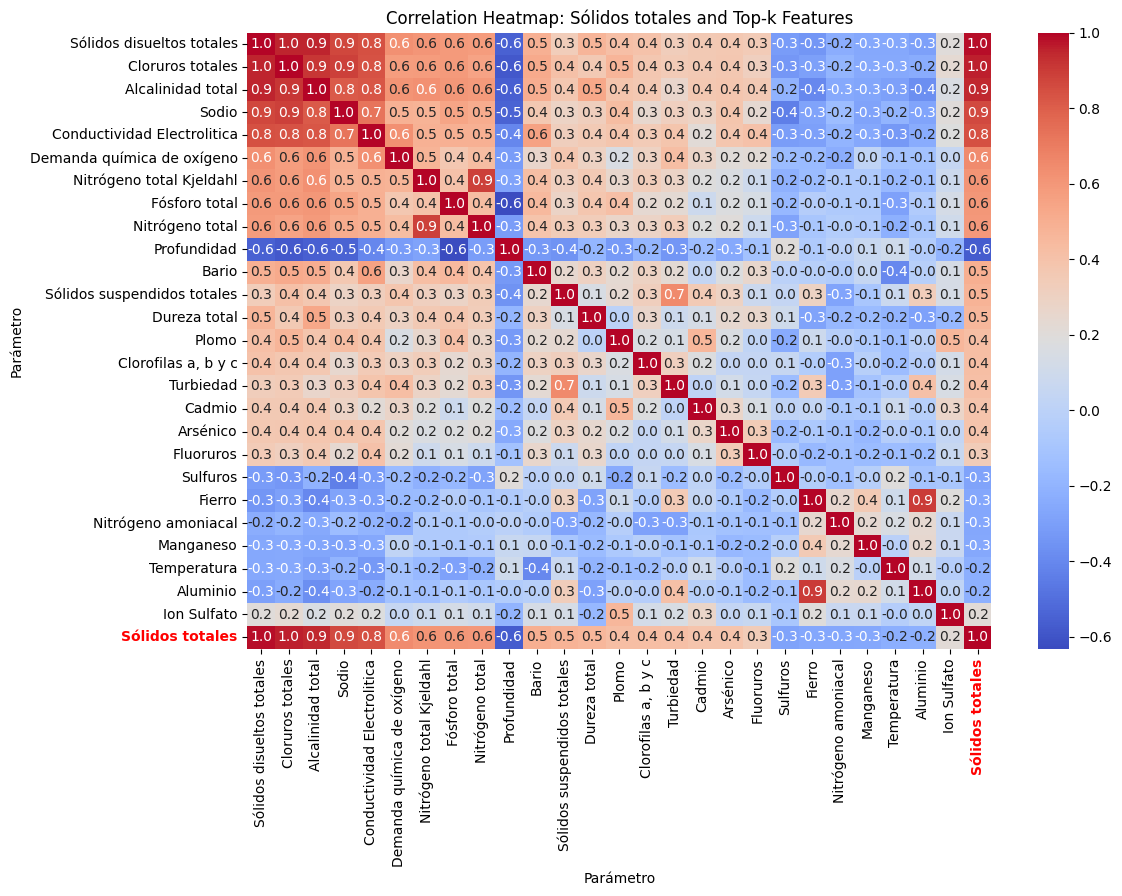

In [ ]:
# Visualize the correlation matrix between the target parameter and K most correlated features
visualize_corr_with_target(data_mp_monthly, features, TARGET_PARAM)

In [ ]:
# Scale the data using MinMaxScaler (value between 0 - 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_mp_monthly[features])
data_scaled = pd.DataFrame(data_scaled, columns=features, index=data_mp_monthly.index)

# Save original min & max values to use to translate predictions later
target_index = features.index(TARGET_PARAM)
target_min = scaler.data_min_[target_index]
target_max = scaler.data_max_[target_index]

In [ ]:
# Create function to split the data into time sequences & split the data
WINDOW_SIZE = 12 # Use 12 months window for time sequences
def create_sequences(data_array, window_size, target_col_index):
  """
  Function used to split the data into sequences
  """
  X, y = [], []
  for i in range(len(data_array) - window_size):
      X.append(data_array[i:i+window_size])
      y.append(data_array[i+window_size, target_col_index])
  return np.array(X), np.array(y)

X, y = create_sequences(data_scaled.values, WINDOW_SIZE, target_index)
sequence_dates = data_scaled.index[WINDOW_SIZE:]
train_mask = sequence_dates.year <= 2023
test_mask  = sequence_dates.year == 2024

X_train = X[train_mask]
y_train = y[train_mask]
X_test  = X[test_mask]
y_test  = y[test_mask]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 156
Testing samples: 10


In [ ]:
# Create model checkpoint to save/restore the best weights obtained during training
checkpoint = ModelCheckpoint(
    "best_model.h5",           # File path to save the model
    monitor="val_loss",        # Monitor the validation loss
    save_best_only=True,       # Only save the model if the monitored metric improves
    mode="min",                # We want to minimize the validation loss
    verbose=1
)

model = Sequential()
model.add(LSTM(24, activation='relu', input_shape=(WINDOW_SIZE, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model (adjust epochs and batch_size as needed)
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test), verbose=0, callbacks=[checkpoint])

model.load_weights("best_model.h5")


Epoch 1: val_loss improved from inf to 0.05602, saving model to best_model.h5



Epoch 2: val_loss did not improve from 0.05602

Epoch 3: val_loss improved from 0.05602 to 0.05080, saving model to best_model.h5



Epoch 4: val_loss improved from 0.05080 to 0.04762, saving model to best_model.h5



Epoch 5: val_loss improved from 0.04762 to 0.04559, saving model to best_model.h5



Epoch 6: val_loss improved from 0.04559 to 0.04515, saving model to best_model.h5



Epoch 7: val_loss improved from 0.04515 to 0.04361, saving model to best_model.h5



Epoch 8: val_loss improved from 0.04361 to 0.04238, saving model to best_model.h5



Epoch 9: val_loss improved from 0.04238 to 0.04086, saving model to best_model.h5



Epoch 10: val_loss improved from 0.04086 to 0.03948, saving model to best_model.h5



Epoch 11: val_loss improved from 0.03948 to 0.03828, saving model to best_model.h5



Epoch 12: val_loss improved from 0.03828 to 0.03724, saving model to best_model.h5



Epoch 13: val_loss improved from 0.03724 to 0.03608, saving model to best_model.h5



Epoch 14: val_loss improved from 0.03608 to 0.03482, saving model to best_model.h5



Epoch 15: val_loss improved from 0.03482 to 0.03419, saving model to best_model.h5



Epoch 16: val_loss improved from 0.03419 to 0.03344, saving model to best_model.h5



Epoch 17: val_loss improved from 0.03344 to 0.03263, saving model to best_model.h5



Epoch 18: val_loss improved from 0.03263 to 0.03102, saving model to best_model.h5



Epoch 19: val_loss improved from 0.03102 to 0.02981, saving model to best_model.h5



Epoch 20: val_loss improved from 0.02981 to 0.02930, saving model to best_model.h5



Epoch 21: val_loss did not improve from 0.02930

Epoch 22: val_loss improved from 0.02930 to 0.02871, saving model to best_model.h5



Epoch 23: val_loss improved from 0.02871 to 0.02743, saving model to best_model.h5



Epoch 24: val_loss improved from 0.02743 to 0.02654, saving model to best_model.h5



Epoch 25: val_loss improved from 0.02654 to 0.02627, saving model to best_model.h5



Epoch 26: val_loss improved from 0.02627 to 0.02485, saving model to best_model.h5



Epoch 27: val_loss improved from 0.02485 to 0.02420, saving model to best_model.h5



Epoch 28: val_loss improved from 0.02420 to 0.02412, saving model to best_model.h5



Epoch 29: val_loss improved from 0.02412 to 0.02255, saving model to best_model.h5



Epoch 30: val_loss improved from 0.02255 to 0.02231, saving model to best_model.h5



Epoch 31: val_loss improved from 0.02231 to 0.02186, saving model to best_model.h5



Epoch 32: val_loss improved from 0.02186 to 0.02143, saving model to best_model.h5



Epoch 33: val_loss improved from 0.02143 to 0.02022, saving model to best_model.h5



Epoch 34: val_loss did not improve from 0.02022

Epoch 35: val_loss improved from 0.02022 to 0.01989, saving model to best_model.h5



Epoch 36: val_loss did not improve from 0.01989

Epoch 37: val_loss did not improve from 0.01989

Epoch 38: val_loss did not improve from 0.01989

Epoch 39: val_loss improved from 0.01989 to 0.01966, saving model to best_model.h5



Epoch 40: val_loss did not improve from 0.01966

Epoch 41: val_loss did not improve from 0.01966

Epoch 42: val_loss did not improve from 0.01966

Epoch 43: val_loss did not improve from 0.01966

Epoch 44: val_loss did not improve from 0.01966

Epoch 45: val_loss did not improve from 0.01966

Epoch 46: val_loss did not improve from 0.01966

Epoch 47: val_loss did not improve from 0.01966

Epoch 48: val_loss did not improve from 0.01966

Epoch 49: val_loss did not improve from 0.01966

Epoch 50: val_loss did not improve from 0.01966


In [ ]:
# Get predictions for 2024 data
y_pred_scaled = model.predict(X_test)

def inverse_transform(value):
    return value * (target_max - target_min) + target_min

y_pred = np.array([inverse_transform(val) for val in y_pred_scaled.flatten()])
y_test_actual = np.array([inverse_transform(val) for val in y_test])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


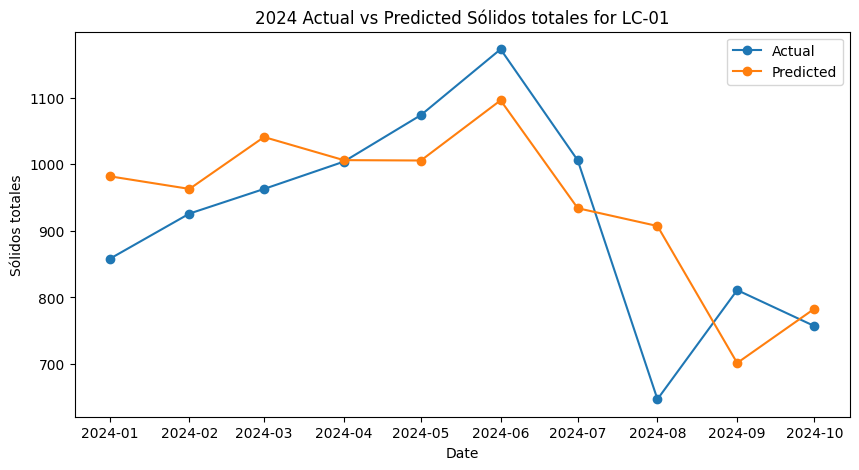

In [ ]:
# Plot the predicted values against the actual 2024 values for the selected parameter
plt.figure(figsize=(10, 5))
plt.plot(sequence_dates[test_mask], y_test_actual, label='Actual', marker='o')
plt.plot(sequence_dates[test_mask], y_pred, label='Predicted', marker='o')
plt.xlabel('Date')
plt.ylabel(TARGET_PARAM)
plt.title(f'2024 Actual vs Predicted {TARGET_PARAM} for {MEASURING_POINT}')
plt.legend()
plt.show()

In [ ]:
# Evaluate the results using
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("Evaluation Metrics for 2024 Data:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Evaluation Metrics for 2024 Data:
MSE: 11900.7069
RMSE: 109.0904
MAE: 85.4136
R² Score: 0.4611


**Make Predictions for 2025**

In [ ]:
forecast_steps = 12  # Forecasting 12 months ahead
last_sequence = data_scaled.values[-WINDOW_SIZE:].copy()  # Start with the last available window
forecast_scaled = []

for i in range(forecast_steps):
    # Predict the next target value using the current window
    pred_scaled = model.predict(last_sequence.reshape(1, WINDOW_SIZE, len(features)))[0, 0]
    forecast_scaled.append(pred_scaled)

    # Create a new row: use the last row's values for all parameters,
    # but update the target parameter with the prediction.
    new_row = last_sequence[-1].copy()
    new_row[target_index] = pred_scaled

    # Roll the window: drop the oldest row and append the new row
    last_sequence = np.vstack([last_sequence[1:], new_row])

# Inverse transform the forecasted target values
forecast = [inverse_transform(val) for val in forecast_scaled]

# Create a date range for 2025 (using month start frequency)
#forecast_dates = pd.date_range(start='2025-01-01', periods=forecast_steps, freq='MS')
last_date = data_scaled.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


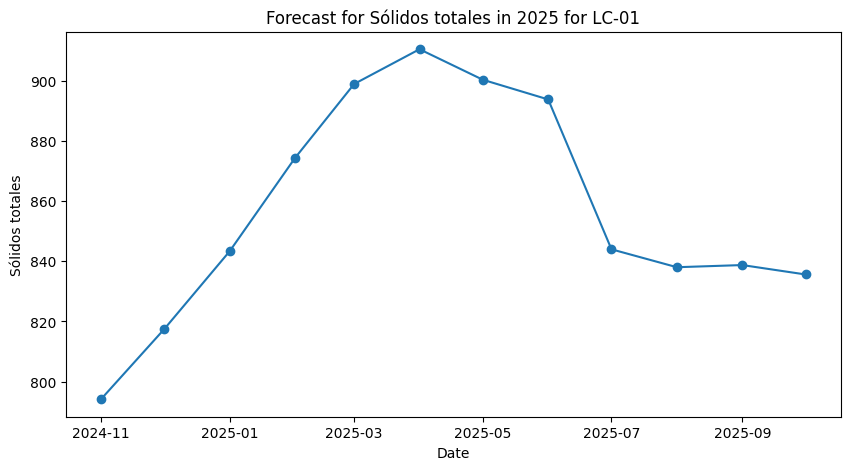

In [ ]:
# Plot the forecasted values for the parameter for 2025
plt.figure(figsize=(10,5))
plt.plot(forecast_dates, forecast, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel(TARGET_PARAM)
plt.title(f'Forecast for {TARGET_PARAM} in 2025 for {MEASURING_POINT}')
plt.show()